**1. Why this project?**


*   I just recently learnt about Python Beautifulsoup and wanted to use the knowledge in a real-world example
*   One of my new year goals is to read more books (both fictions and non-fictions) so I thought let's scrape some data on what are the most best-selling books on Amazon
* I would be mainly focus on top 100 best selling books from this URL: https://www.amazon.sg/gp/bestsellers/books

**Many thanks to my following Internet resources:**


*   https://www.datacamp.com/tutorial/amazon-web-scraping-using-beautifulsoup





In [1]:
# Install beautifulsoup
!pip3 install beautifulsoup4

In [2]:
# Import necessary libraries that I might use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests


**2. Project Overview:**


1.   Identify necessary parent tag in HTML
2.   Extract all the data I'll need including: Book Name, Author, Rating, Customers Rated, Price, Type
3. Loop through 2 pages in total to extract top 100 books




In [3]:
# Numbers of pages we will loop through
no_pages = 2

# Define web scraping User Agent
def get_data(pageNo):
  headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

  # Send a GET request to my designated URL and loop through 2 pages
  r = requests.get('https://www.amazon.sg/gp/bestsellers/books/ref=zg_bs_pg_'+str(pageNo)+'_books?ie=UTF8&pg='+str(pageNo), headers = headers)

  # Get the HTML content of the URL
  content = r.content
  soup = BeautifulSoup(content)

  # Create an empty list for our scraping data
  alls = []
  for d in soup.findAll('div', attrs={'class':'zg-grid-general-faceout'}):
    name = d.find('div', attrs={'class':'a-section a-spacing-mini _cDEzb_noop_3Xbw5'})
    n = name.find_all('img', alt=True)
    author = d.find('span', attrs={'class':'a-size-small a-color-base'})
    #users_rated = d.find('span', attrs={'class':'a-size-small'})
    price = d.find('span', attrs={'class':lambda x: x and 'price' in x})

# Rating is serperated as it's usually marked as stars icon on Amazon web page
    rating_tag = d.find('a', attrs={'aria-label': True})
    if rating_tag:
        aria_label = rating_tag['aria-label']
        # Extract the float number at the beginning: "xxx out of 5 stars"
        match = re.search(r'([0-5]\.\d)\s+out of 5', aria_label)
        if match:
            rating = match.group(1)

# Similar to rating, I seperate numbers of customer reviews as it's combined with rating in the HTML code
    number_of_reviews_tag = d.find('a', attrs={'aria-label':True})
    if number_of_reviews_tag:
      aria_label_reviews = number_of_reviews_tag['aria-label']
      # Extract the number after "xxx stars"
      match_reviews = re.search(r'([\d,]+)\s+ratings', aria_label_reviews)
      if match:
        number_of_reviews = match_reviews.group(1)


    all1=[]

    if name is not None:
      all1.append(n[0]['alt'])
    else:
      all1.append("Unknown product")

    if author is not None:
      all1.append(author.text)
    elif author is None:
      author = d.find('span', attrs={'class':'a-size-small a-color-base'})
      if author is not None:
        all1.append(author.text)
      else:
        all1.append('0')

    if rating is not None:
      all1.append(rating)
    else:
      all1.append('0')

    if number_of_reviews is not None:
      all1.append(number_of_reviews)
    else:
      all1.append('0')

    if price is not None:
      all1.append(price.text)
    else:
      all1.append('0')
    alls.append(all1)
  return alls

In [4]:
results = []

for i in range(1, no_pages+1):
  results.append(get_data(i))
flatten_code = lambda l: [item for sublist in l for item in sublist]
df = pd.DataFrame(flatten_code(results),columns=['Book Name','Author','Rating', 'Number of Reviews', 'Price'])
df.to_csv('amazon_bestselling_book.csv', index=False, encoding='utf-8')

<ipython-input-3-b9623d79f3a2>:17: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for d in soup.findAll('div', attrs={'class':'zg-grid-general-faceout'}):


In [5]:
df = pd.read_csv('amazon_bestselling_book.csv')
df.head()

,Book Name,Author,Rating,Number of Reviews,Price
0,Indestructibles: Big and Little: A Book of Opp...,Carolina Búzio,4.9,423,S$5.96
1,Productive Failure: Unlocking Deeper Learning ...,Manu Kapur,5.0,48,S$26.07
2,The Elements Book: A Visual Encyclopedia of th...,DK,4.9,"2,451",S$47.45
3,"Indestructibles: Baby, Find the Shapes!: Chew ...",Ekaterina Trukhan,4.8,916,S$5.72
4,Atomic Habits: The life-changing million copy ...,James Clear,4.8,"114,598",S$33.81


In [6]:
# Let's see how many rows we have
df.shape

(60, 5)

In [7]:
# What is the datatype of all the columns?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          60 non-null     object 
 1   Author             60 non-null     object 
 2   Rating             60 non-null     float64
 3   Number of Reviews  60 non-null     object 
 4   Price              60 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.5+ KB


In [8]:
# Since price include "S$", let's remove that before we try to find any insight
df['Price'] = df['Price'].str.replace('S$', '')

# Convert Price column into number
df['Price'] = pd.to_numeric(df['Price'])

# Remove comma out of Number of Reviews column
df['Number of Reviews'] = df['Number of Reviews'].str.replace(',', '')

# Convert Number of Reviews column into number
df['Number of Reviews'] = pd.to_numeric(df['Number of Reviews'])

# Convert Ratings into number
df['Rating'] = pd.to_numeric(df['Rating'])

# Output results
df.head()

,Book Name,Author,Rating,Number of Reviews,Price
0,Indestructibles: Big and Little: A Book of Opp...,Carolina Búzio,4.9,423,5.96
1,Productive Failure: Unlocking Deeper Learning ...,Manu Kapur,5.0,48,26.07
2,The Elements Book: A Visual Encyclopedia of th...,DK,4.9,2451,47.45
3,"Indestructibles: Baby, Find the Shapes!: Chew ...",Ekaterina Trukhan,4.8,916,5.72
4,Atomic Habits: The life-changing million copy ...,James Clear,4.8,114598,33.81


In [9]:
# Verify the data types of Data Frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          60 non-null     object 
 1   Author             60 non-null     object 
 2   Rating             60 non-null     float64
 3   Number of Reviews  60 non-null     int64  
 4   Price              60 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ KB


In [10]:
# Let's count how many 0 we have in this dataset
(df == "0").sum()

,0
Book Name,0
Author,3
Rating,0
Number of Reviews,0
Price,0


It looks like the data is quite complete. No alarming large amount of missing values (i.e 0)

In [11]:
# Who has the highest-priced book among the best-sellers in Singapore? Let's see top 10
top_10 = df.sort_values(by='Price', ascending=False).head(10)
top_10

,Book Name,Author,Rating,Number of Reviews,Price
38,The Elements of Quantitative Investing,Giuseppe A Paleologo,4.0,10,75.31
26,How Countries Go Broke: Principles for Navigat...,Ray Dalio,5.0,2,58.57
40,A Different Kind of Power: A Memoir,Jacinda Ardern,5.0,1,49.83
2,The Elements Book: A Visual Encyclopedia of th...,DK,4.9,2451,47.45
25,The Anxious Generation: How the Great Rewiring...,Jonathan Haidt,4.7,2951,43.04
20,How Countries Go Broke: The Big Cycle,Ray Dalio,5.0,2,42.50
9,Umma: A Korean Mom's Kitchen Wisdom and 100 Fa...,Sarah Ahn,4.8,293,40.77
11,Heart Lamp: Selected Stories,Dr Banu Mushtaq,4.4,92,40.68
35,"Disney Frozen Elsa, Anna, Olaf, and More! - Me...",P I Kids,4.7,6607,37.81
13,A Different Kind of Power,Jacinda Ardern,5.0,1,36.22


J.K.Rowling is on a roll with two book sets in the list of highest price. Understandable as these are box set. Let's visualise the results for better insights

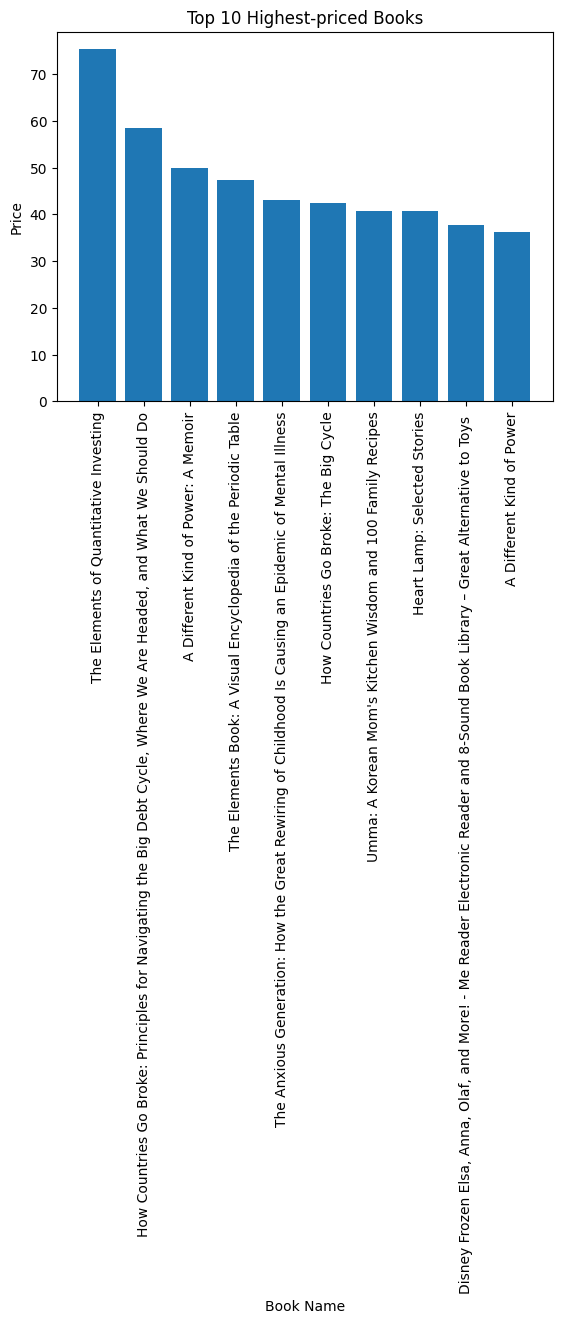

In [12]:
plt.bar(top_10['Book Name'], top_10['Price'])
plt.xlabel('Book Name')
plt.ylabel('Price')
plt.title('Top 10 Highest-priced Books')
plt.xticks(rotation=90)
plt.show()

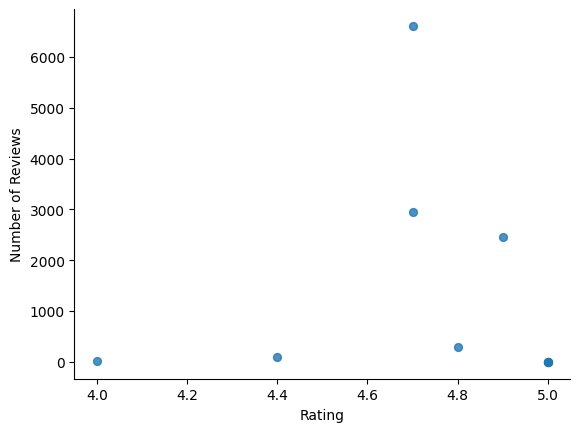

In [13]:
# Let's look at the correlation between the number of reviews and ratings. Is the most popular book the highest rating?

top_10.plot(kind='scatter', x='Rating', y='Number of Reviews', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
# Output correlation between number of reviews and rating
correlation = df['Number of Reviews'].corr(df['Rating'])
print(f"The correlation between the number of reviews and rating is: {correlation:.2f}")

The correlation between the number of reviews and rating is: 0.09


It seems like the correlation between number of reviews and the ratings is very negligible, only at 0.09.

In [15]:
# Let's look at the top 5 books with the highest number of reviews
top_5 = df.sort_values(by='Number of Reviews', ascending=False).head(5)
top_5

,Book Name,Author,Rating,Number of Reviews,Price
29,"The Boy, the Mole, the Fox and the Horse: A Gr...",Charlie Mackesy,4.9,114713,22.64
4,Atomic Habits: The life-changing million copy ...,James Clear,4.8,114598,33.81
46,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,43094,22.99
17,1984: 75th Anniversary,George Orwell,4.7,37124,17.50
5,The Psychology of Money: Timeless lessons on w...,Morgan Housel,4.7,21702,27.31


'The Boy, the Mole, the Fox and the Horse' is the most popular with over 114k reviews. The book seems to include beautiful illustration and uplifting messages. I totally understand why it's so popular among young readers. 'Atomic Habits' and 'The Psychology of Money' are both my top favorites. Would definitely recommend this to a friend.

**3. New things I learnt:**


*   User_agent: It's used to identify my script to the web server as if i were a real browser (like Chrome or Firefox). Without user_agent, my code can look suspicious under Amazon guideline (like it's coming from a bot or script)
*   HTML structure: Being able to understand basic HTML has helped me to identify the critical texts/strings to scrape what I need from the web. Amazon HTML changes from time to time so I have to iterate and change my codes for a few times before being able to output the final csv.

** 4. Conclusion**

* This project definitely helps me get out of my comfort zone and try something new and useful that can be used in my everyday life / work (be it scraping links or reviews of products)
* Would love to test out different codes to scrape the web for reviews and customer sentiment. Maybe I will try in my next side project ;) Had a lot of fun learning!
